In [1]:
import sys
print(sys.executable)
import torch
print (torch.__version__)
import torchvision
print(torchvision.__version__)


C:\Users\pearl\Anaconda3\envs\pytorchEnv\python.exe
0.4.0
0.2.1


In [2]:
import argparse
parser=argparse.ArgumentParser()
FLAGS=parser.parse_args(args=[])
FLAGS.batchsize=128
FLAGS.w_epoch=1000
FLAGS.w_printepoch=1
FLAGS.init_lr=1e-3
FLAGS.lrchange=0.9
FLAGS.BreakBasedLr_lr=1e-8
FLAGS.init_alpha=0

FLAGS.minvalid_avgover=5

FLAGS.save_name='mnist_lenet5_map_avgover_alpha0'

# dataset

In [3]:
import torchvision.datasets
import torchvision.transforms

transform1=torchvision.transforms.ToTensor()
transform2=lambda x: 2*(x-0.5)
transform12=torchvision.transforms.Compose([transform1,transform2])
datasets_mnist_train=torchvision.datasets.MNIST('../data', train=True, download=False, transform=transform12)
datasets_mnist_test=torchvision.datasets.MNIST('../data', train=False, transform=transform12)


In [4]:
print('train size %d'% len(datasets_mnist_train.train_data) )
print(' test size %d'% len(datasets_mnist_test.test_data) )
print('image size',datasets_mnist_train.train_data[0].size() )
N = 60000.  # number of data points in the training set

train size 60000
 test size 10000
image size torch.Size([28, 28])


In [5]:
import torch.utils.data.dataset
import torch.utils.data
import torch


test_loader=torch.utils.data.DataLoader(datasets_mnist_test,batch_size=FLAGS.batchsize )
N=50000
train_subset=torch.utils.data.dataset.Subset(datasets_mnist_train,range(N))
valid_subset=torch.utils.data.dataset.Subset(datasets_mnist_train,range(N,60000))
train_loader=torch.utils.data.DataLoader(train_subset, batch_size=FLAGS.batchsize,shuffle=True) 
valid_loader=torch.utils.data.DataLoader(valid_subset, batch_size=FLAGS.batchsize )


# utils

In [6]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
class History(object):
    def __init__(self):
        self.loss=[]
        self.regloss=[]
        self.totalloss=[]
        self.testerr=[]  
        self.validerr=[]

# model

In [9]:
import torch.nn
import torch
import torch.autograd
import math
import random
import numpy
import copy
import operator

random.seed(1)
numpy.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [10]:
class ARDConv2d(torch.nn.modules.Module):
    def __init__(self, in_channels, out_channels,initalpha):
        super(ARDConv2d, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, 5,5))
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        self.dim = out_channels
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)      
        
    def forward(self, input_):# batchsize,inchannel, 28x28
        output = torch.nn.functional.conv2d(input_, self.weights , self.bias )    
        return output
        
    def regularization(self):  
        reg=torch.sum(self.weights.pow(2)*self.alpha.view(-1,1,1,1))
        return 0.5*reg

In [11]:
class ARDDense(torch.nn.modules.Module):
    def __init__(self, in_features, out_features,initalpha):
        super(ARDDense, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor( out_features,in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))        
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        self.dim = in_features
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)        
            
    def forward(self, inputx):    
        o=torch.nn.functional.linear(inputx, self.weights,self.bias)    
        return o
    
    def regularization(self): 
        reg=torch.sum(self.weights.pow(2)*self.alpha)
        return 0.5*reg

In [12]:
class LeNet5_MNIST(torch.nn.Module):
    def __init__(self):
        super(LeNet5_MNIST, self).__init__()        
        convs=[ARDConv2d(1,20,FLAGS.init_alpha),torch.nn.ReLU(), torch.nn.MaxPool2d(2),
               ARDConv2d(20,50,FLAGS.init_alpha),torch.nn.ReLU(), torch.nn.MaxPool2d(2) ]
        self.convs=torch.nn.Sequential(*convs).cuda()         
        fcs = [ARDDense(800, 500,FLAGS.init_alpha), torch.nn.ReLU(),
               ARDDense(500, 10,FLAGS.init_alpha)]
        self.fcs = torch.nn.Sequential(*fcs).cuda()
             
    def forward(self, x):
        o = self.convs(x)
        o = o.view(o.size(0), -1)
        o=self.fcs(o)
        return o
    
    def regularization(self):
        regularization = 0.0
        for m in self.modules():
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                regularization += m.regularization() 
        return regularization

In [13]:
model = LeNet5_MNIST()
model = model.cuda()
lossfunc=torch.nn.CrossEntropyLoss()

# run

In [14]:
def oneThroughdataset_test(dataloader ):    
    loss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.eval()       
    for ibatch, (input_, target) in enumerate(dataloader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)
        loss = lossfunc(output, target_var)       
        acc = accuracy(output.data, target, topk=(1,))[0]    
        loss_avg.update(loss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
    return loss_avg.avg, predictionErr_avg.avg

In [15]:
def oneThroughdataset_train(optimizer):   
    loss_avg = AverageMeter()
    regloss_avg = AverageMeter()
    totalloss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.train()
    for ibatch, (input_, target) in enumerate(train_loader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)        
        loss = lossfunc(output, target_var)
        regloss=model.regularization()/N
        totalloss = loss +  regloss   
        totalloss = totalloss.cuda()
        acc = accuracy(output.data, target, topk=(1,))[0]   
        
        loss_avg.update(loss.data.item(), input_.size(0))
        regloss_avg.update(regloss.data.item(), input_.size(0))
        totalloss_avg.update(totalloss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
        
        optimizer.zero_grad()
        totalloss.backward()
        optimizer.step()
          
    return loss_avg.avg, regloss_avg.avg,  totalloss_avg.avg, predictionErr_avg.avg

In [16]:
import numpy
def z_step(history):
    last1,last2=1e+10,1e+10
    
    historyValidErr=[]
    
    bestavgvalid,storevalid,storetest,storeepoch=100,100,100,-1
    
    optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': FLAGS.init_lr}])
    learningrate=FLAGS.init_lr
    for w_iter in range(FLAGS.w_epoch):    
        meanloss,meanregloss,meantotalloss,predictionerr  =oneThroughdataset_train(optimizer)
        validloss,validerr=oneThroughdataset_test(valid_loader)
        testloss,testerr=oneThroughdataset_test(test_loader)
            
        history.loss.append( meanloss )
        history.regloss.append( meanregloss)
        history.totalloss.append(meantotalloss )
        history.testerr.append(testerr)
        history.validerr.append(validerr)
        
        for tmpd in range(len(historyValidErr)-1):
            historyValidErr[tmpd]=historyValidErr[tmpd+1]
        if len(historyValidErr)<FLAGS.minvalid_avgover:
            historyValidErr.append(validerr)
        else:
            historyValidErr[-1]=validerr
            
        
        if  numpy.mean(historyValidErr)<bestavgvalid:
            bestavgvalid=numpy.mean(historyValidErr)
            storevalid=validerr
            storetest=testerr
            storeepoch=w_iter
            
            state=dict()
            state['statedict']=model.state_dict()
            state['alpha']=FLAGS.init_alpha
            state['testerr']=testerr
            state['validerr']=validerr
            state['witer']=w_iter
            torch.save(state, '{}-statedict-bestvalid.ckpt'.format(FLAGS.save_name) )   

        print('w {} {:.1e} err%Trn vld test={:.2f} {:.2f} {:.2f} lr={:.1e}'.format(w_iter,
                   meantotalloss,predictionerr,validerr,testerr,learningrate),end=' ')
        print('bstAvgVld vld test iter={:.3f} {:.2f} {:.2f} {}'.format(bestavgvalid,storevalid,storetest,storeepoch))
        
        
        if  (last2-last1)/last2<0.001 and (last1-meantotalloss)/last1<0.001:
            learningrate=learningrate* FLAGS.lrchange 
            optimizer.param_groups[0]['lr']=learningrate

        if learningrate < FLAGS.BreakBasedLr_lr:
            break
            
        if meantotalloss==0:
            break
            
        last2=last1
        last1=meantotalloss 
    return history,storetest,storeepoch

In [17]:
history=History()
history,besttesterr,bestatepoch=z_step(history)
torch.save(history, '{}-history.ckpt'.format(FLAGS.save_name) )

w 0 2.0e-01 err%Trn vld test=5.67 1.95 1.71 lr=1.0e-03 bstAvgVld vld test iter=1.950 1.95 1.71 0
w 1 4.6e-02 err%Trn vld test=1.42 1.96 2.09 lr=1.0e-03 bstAvgVld vld test iter=1.950 1.95 1.71 0
w 2 3.0e-02 err%Trn vld test=0.96 1.40 1.23 lr=1.0e-03 bstAvgVld vld test iter=1.773 1.40 1.23 2
w 3 2.3e-02 err%Trn vld test=0.78 1.15 0.99 lr=1.0e-03 bstAvgVld vld test iter=1.478 1.15 0.99 3
w 4 1.6e-02 err%Trn vld test=0.56 1.23 1.07 lr=1.0e-03 bstAvgVld vld test iter=1.266 1.23 1.07 4
w 5 1.3e-02 err%Trn vld test=0.46 1.31 1.09 lr=1.0e-03 bstAvgVld vld test iter=1.248 1.31 1.09 5
w 6 1.1e-02 err%Trn vld test=0.39 1.42 1.25 lr=1.0e-03 bstAvgVld vld test iter=1.248 1.31 1.09 5
w 7 1.1e-02 err%Trn vld test=0.36 1.07 1.16 lr=1.0e-03 bstAvgVld vld test iter=1.236 1.07 1.16 7
w 8 7.6e-03 err%Trn vld test=0.25 1.15 0.95 lr=1.0e-03 bstAvgVld vld test iter=1.236 1.07 1.16 7
w 9 9.2e-03 err%Trn vld test=0.33 1.04 1.13 lr=1.0e-03 bstAvgVld vld test iter=1.198 1.04 1.13 9
w 10 1.0e-02 err%Trn vld test=

w 83 1.4e-09 err%Trn vld test=0.00 0.74 0.63 lr=8.1e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 84 9.0e-10 err%Trn vld test=0.00 0.73 0.64 lr=8.1e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 85 5.4e-10 err%Trn vld test=0.00 0.71 0.60 lr=8.1e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 86 6.0e-10 err%Trn vld test=0.00 0.74 0.62 lr=8.1e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 87 2.1e-02 err%Trn vld test=0.37 1.13 1.17 lr=8.1e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 88 6.5e-03 err%Trn vld test=0.19 0.91 0.92 lr=7.3e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 89 1.3e-03 err%Trn vld test=0.03 0.81 0.92 lr=7.3e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 90 6.8e-05 err%Trn vld test=0.00 0.80 0.80 lr=7.3e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 91 9.0e-06 err%Trn vld test=0.00 0.79 0.81 lr=7.3e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 92 5.7e-06 err%Trn vld test=0.00 0.78 0.80 lr=7.3e-04 bstAvgVld vld test iter=0.708 0.70 0.64 70
w 93 4.5e-

w 165 9.1e-07 err%Trn vld test=0.00 0.87 0.66 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 166 7.2e-07 err%Trn vld test=0.00 0.85 0.66 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 167 6.0e-07 err%Trn vld test=0.00 0.84 0.67 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 168 5.0e-07 err%Trn vld test=0.00 0.84 0.66 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 169 4.2e-07 err%Trn vld test=0.00 0.84 0.66 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 170 3.6e-07 err%Trn vld test=0.00 0.84 0.66 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 171 3.1e-07 err%Trn vld test=0.00 0.82 0.66 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 172 2.7e-07 err%Trn vld test=0.00 0.83 0.66 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 173 2.4e-07 err%Trn vld test=0.00 0.83 0.64 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 174 2.1e-07 err%Trn vld test=0.00 0.83 0.64 lr=4.8e-04 bstAvgVld vld test iter=0.706 0.70

w 247 2.0e-09 err%Trn vld test=0.00 0.73 0.69 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 248 1.5e-09 err%Trn vld test=0.00 0.73 0.69 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 249 1.1e-09 err%Trn vld test=0.00 0.73 0.69 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 250 8.9e-10 err%Trn vld test=0.00 0.72 0.69 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 251 6.9e-10 err%Trn vld test=0.00 0.72 0.68 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 252 4.7e-10 err%Trn vld test=0.00 0.72 0.68 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 253 3.2e-10 err%Trn vld test=0.00 0.72 0.69 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 254 2.6e-10 err%Trn vld test=0.00 0.72 0.68 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 255 1.2e-10 err%Trn vld test=0.00 0.71 0.69 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70 0.70 112
w 256 1.3e-10 err%Trn vld test=0.00 0.71 0.69 lr=4.3e-04 bstAvgVld vld test iter=0.706 0.70

Text(112,0.7,'0.700')

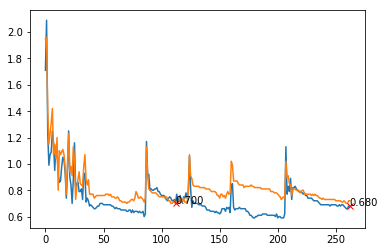

In [20]:
import matplotlib.pyplot
matplotlib.pyplot.plot(history.testerr)
matplotlib.pyplot.plot(history.validerr)

y=history.testerr
x=len(y)-1
matplotlib.pyplot.plot(x,y[x],'x',color='r')
matplotlib.pyplot.annotate( '{:.3f}'.format(y[x]),xy=(x,y[x]))

x=bestatepoch
matplotlib.pyplot.plot(x,y[x],'x',color='r')
matplotlib.pyplot.annotate( '{:.3f}'.format(y[x]),xy=(x,y[x]))

#matplotlib.pyplot.ylim([0.5,3.0])


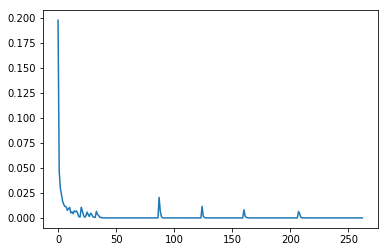

In [21]:
import matplotlib.pyplot
matplotlib.pyplot.plot(history.loss)
#matplotlib.pyplot.ylim([0,0.04])

# load

0.7


Text(112,0.7,'0.700')

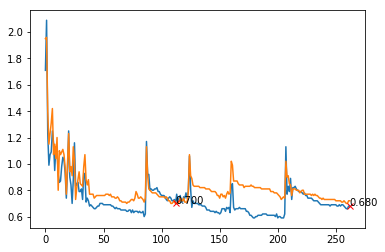

In [18]:
class History(object):
    def __init__(self):
        self.loss=[]
        self.regloss=[]
        self.totalloss=[]
        self.testerr=[]  
        
import torch
file='mnist_lenet5_map_avgover_alpha0-history.ckpt'
history=torch.load(file)


import matplotlib.pyplot
matplotlib.pyplot.plot(history.testerr)
matplotlib.pyplot.plot(history.validerr)

y=history.testerr
x=len(y)-1
matplotlib.pyplot.plot(x,y[x],'x',color='r')
matplotlib.pyplot.annotate( '{:.3f}'.format(y[x]),xy=(x,y[x]))


resumefile='mnist_lenet5_map_avgover_alpha0-statedict-bestvalid.ckpt'
resume_dict = torch.load(resumefile, map_location='cpu')
ard_keys, resume_keys = list(model.state_dict().keys()), list(resume_dict['statedict'].keys())
for i in range(len(ard_keys)):
    model.state_dict()[ard_keys[i]].copy_(resume_dict['statedict'][resume_keys[i]])
    
testloss,testerr=oneThroughdataset_test(test_loader)
print(testerr)


x=resume_dict['witer']
matplotlib.pyplot.plot(x,y[x],'x',color='r')
matplotlib.pyplot.annotate( '{:.3f}'.format(y[x]),xy=(x,y[x]))
